In [11]:
# BrainStrom 2022
# Tutorial for classification with Neural nework (Feedforward network and Convolutional network)
# Resources:
# -2D convolution layer: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
# - https://machinelearningknowledge.ai/pytorch-conv2d-explained-with-examples/
# -Visualization of conv layer: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
# -Dropout layer: https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html
# AK, June-26-2022
# =========================================================================
%reset -f
import os, sys
from pprint import pprint as pp

# Define paths 
DIR_HERE = os.path.dirname(os.path.realpath("__file__"))
sys.path.append('../Others')

# Load basic modules 
import numpy as np
import matplotlib.pyplot as plt

# Load PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torchvision import datasets, transforms

%who

DIR_HERE	 F	 datasets	 nn	 np	 optim	 os	 plt	 pp	 
summary	 sys	 torch	 transforms	 


In [215]:
# General note
# =========================================================================
# Keep in mind that classification analyses typically take the following basic steps
# Step1: Prepare data
# - load or simulate features data (e.g., EEG) and target label
# - slit data to test sets and training set
# - (for real studies, this is the hardest step)
# 
# Step2: Fit model
# - do model specific optimization 
# - do cross validation
# - check hyper-parameters 
# 
# Step3: Evaluate results
# - yay, this is fun!

In [12]:
# -----------------------------
# Step0: Before we start... 
# -----------------------------

# What is MNIST dataset?
# http://yann.lecun.com/exdb/mnist/

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used:", device)


Device used: cpu


In [13]:
# -----------------------------
# Step1: Prepare data
# -----------------------------

# Define "transform", which adjusts data 
# https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html
transform = transforms.Compose(
    [transforms.ToTensor(),                      # [H, W, C] -> [C, H, W]
     transforms.Normalize((0.5, ), (0.5, ))])    # normalize (mean =.5, sd = .5)


# Load (download for the first run) MNIST data
# Each image (C = channel, H = height, W = width) = (1, 28, 28) = 784 pixels
# https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST

#Train data (channel, height, width) = (1,28,28) 60000 images
train_dataset = datasets.MNIST(root='./data', 
                                        train = True, # Get training dataset
                                        download = True,
                                        transform = transform)

#Test data (channel, height, width) = (1,28,28) 10000 images
test_dataset = datasets.MNIST(root='./data', 
                                        train = False, # Get test dataset
                                        download = True, 
                                        transform = transform)

# Data too large?
# RandomSubsetSampler

image size =  torch.Size([1, 28, 28])
labels =  5


Text(0.5, 1.0, 'Label = 5')

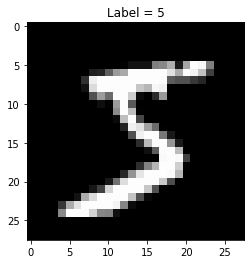

In [14]:
# Checking data and iteractor behavior
batch_iterator = iter(train_dataset) 
image, label = next(batch_iterator) 
print("image size = ", image.size())
print("labels = ", label)

plt.imshow(image[0].numpy().reshape(28,28), cmap='gray')
plt.title("Label = %d" % (label))

In [16]:
# -----------------------------
# Step 2: Define model
# -----------------------------


#------------------------------
# Define hyperparameters
n_epochs = 3            # how many times to repeat learning epochs
n_batch = 64            # how many examples to give in one epoch
learning_rate = .001    # learning rate of the oprimizer
im_height = 28          # heigh of image
im_witdh = 28           # width of image
output_size = 10        # number of target (i.e., unique hand-written numbers)
# image_size = np.prod(imges[0].numpy().shape)

#------------------------------    
# Define convolutional network model (convolutional network)
class Net(nn.Module):
    def __init__(self, im_height, im_witdh, output_size):
        # Initialize module
        super(Net, self).__init__()
        self.input_size = [im_height, im_witdh]
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1)
        
        # Dropout layers
        self.dropout = nn.Dropout(p = .5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))      # (Batch,  1, 28, 28) -> (Batch, 32, 26, 26)
        x = F.relu(self.conv2(x))      # (Batch, 32, 26, 26) -> (Batch, 64, 24, 24)

        x = F.max_pool2d(x, 2)         # (Batch, 64, 24, 24) -> (Batch, 64, 12, 12)
        x = self.dropout(x)
        
        x = torch.flatten(x, 1)        # (Batch, 64, 12, 12) -> (Batch, 9216)
        x = F.relu(self.fc1(x))        # (Batch, 9216) -> (Batch, 128)
        x = self.fc2(x)                # (Batch, 128) -> (Batch, 10)
        return x
    
# Instantiate model
model = Net(im_height, im_witdh, output_size).to(device)
summary(model, (n_batch, 1, im_witdh, im_height), verbose = 2, col_width=16, col_names=["kernel_size", "output_size", "num_params"])


#------------------------------
# Define loss function
# CrossEntropyLoss = softmax + cross entropy error
criterion = nn.CrossEntropyLoss()

#------------------------------
# Define optimier
optimizer = optim.Adam(model.parameters(), lr = learning_rate)


#------------------------------
# Define data loader, which generates batch efficiently in PyTorch
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# https://blog.paperspace.com/dataloaders-abstractions-pytorch/

# Data loader for training
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size = 60,
                                            shuffle = True)

#Data loader for testing
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                            batch_size = 10,
                                            shuffle = False)

Layer (type:depth-idx)                   Kernel Shape     Output Shape     Param #
Net                                      --               [64, 10]         --
├─Conv2d: 1-1                            [3, 3]           [64, 32, 26, 26] 320
│    └─weight                            [1, 32, 3, 3]                     ├─288
│    └─bias                              [32]                              └─32
├─Conv2d: 1-2                            [3, 3]           [64, 64, 24, 24] 18,496
│    └─weight                            [32, 64, 3, 3]                    ├─18,432
│    └─bias                              [64]                              └─64
├─Dropout: 1-3                           --               [64, 64, 12, 12] --
├─Linear: 1-4                            --               [64, 128]        1,179,776
│    └─weight                            [9216, 128]                       ├─1,179,648
│    └─bias                              [128]                             └─128
├─Linear: 1-5         

In [17]:
# -----------------------------
# Step 3: Train model
# -----------------------------

# change model as "training mode"
model.train()  

# Loop over n_epoch times
for epoch in range(n_epochs): 
    loss_sum = 0
    acc_sum = 0

    for inputs, labels in train_dataloader:        
        # CPU/GPU stuff (don't worry)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Initialize gradient of optimizer
        optimizer.zero_grad()

        # Forward path
        outputs = model(inputs)
        
        # Calculate loss: difference between output and label
        loss = criterion(outputs, labels)
        
        # Keep track of the progress of learning
        loss_sum += loss
        _, preds = torch.max(outputs, 1) # prediction = max softmax output
        acc_sum += torch.sum(preds == labels.data)

        # Backward path (Backpropagation!)
        loss.backward()

        # Update weights
        optimizer.step()

    # Display learning progress
    epoch_loss = loss_sum.item() / len(train_dataloader) # cumulative loss/ batch size
    epoch_acc = acc_sum.double() / len(train_dataloader.dataset) # cummlative count of correct prediction / data size
    print(f"Epoch: {epoch+1}/{n_epochs}, Loss: {epoch_loss}, Acc: {epoch_acc}")

    # Save trained weights?
    #torch.save(model.state_dict(), 'model_weights.pth')

Epoch: 1/3, Loss: 0.14684423828125, Acc: 0.95465
Epoch: 2/3, Loss: 0.05215789031982422, Acc: 0.9836833333333334
Epoch: 3/3, Loss: 0.03689114379882812, Acc: 0.98825


tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


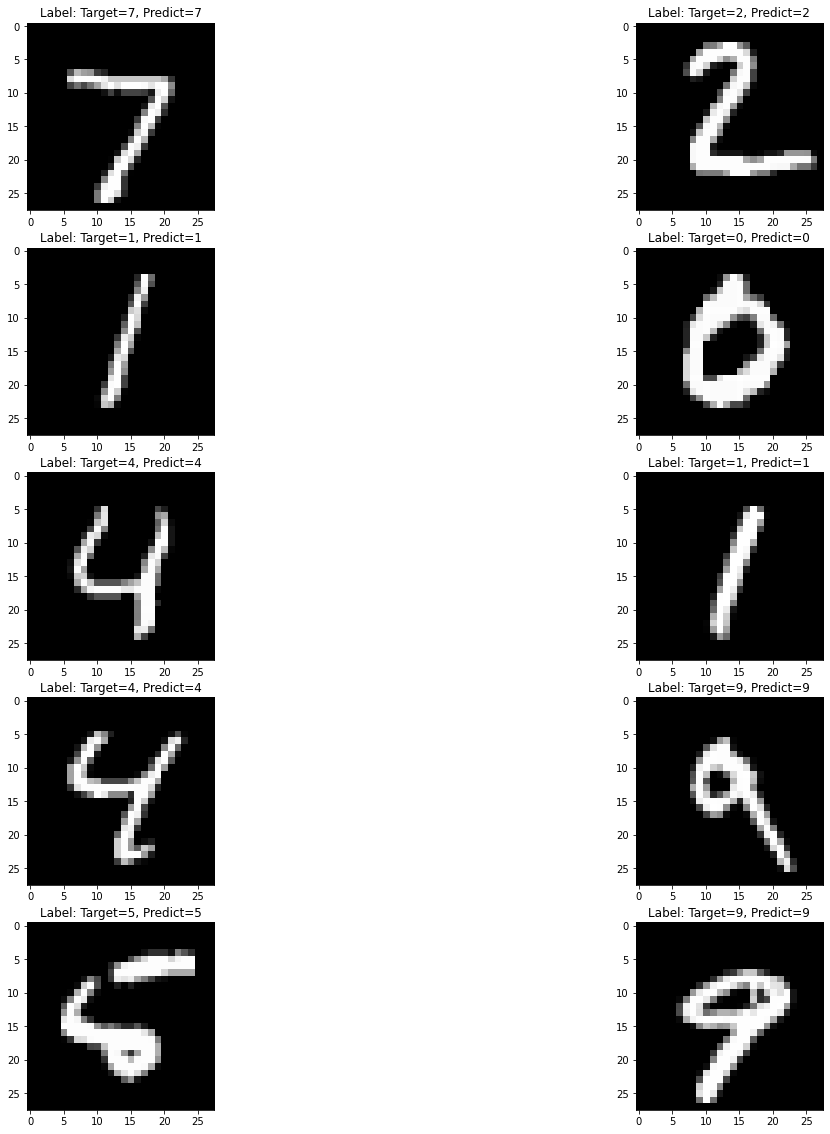

In [18]:
# Step 4: Evaluate model
# -----------------------------

# Prepare test data to handle easily 
batch_iterator = iter(test_dataloader) # Make iterator out ot test_dataloader
images, labels = next(batch_iterator)  # Get first group of test batch
model.eval()  # change model as "evaluating mode"

# Make predictions to one test batch
with torch.set_grad_enabled(False):    # stop calculating gradient (stop learning)
    outputs = model(images)            # forward path
    _, preds = torch.max(outputs, 1)   # make prediction (take max of softmax function)

    
# Plot predicted label and correct label
_, axs = plt.subplots(5, 2, figsize=(20, 20))
axs = axs.flatten()

for i in range(len(preds)): 
    axs[i].imshow(images[i].numpy().reshape(28,28), cmap='gray')
    axs[i].title.set_text("Label: Target={}, Predict={}".format(labels[i].numpy(), preds[i].numpy()))
    

plt.show()

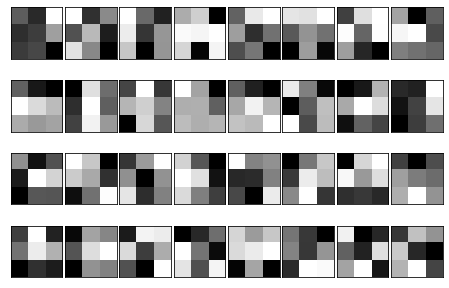

In [70]:
# Extract all parameters from the trained model
for name, param in model.named_parameters(): params[name] = param

# Filters
filters = params['conv1.weight'].detach().numpy()
FN, C, FH, FW = filters.shape


# Plot
nx = 8
margin = 3
scale = 10
ny = int(np.ceil(FN / nx))
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(FN):
    ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

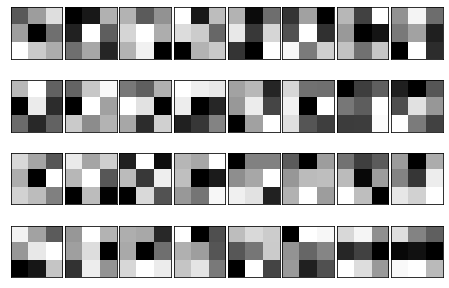

In [71]:
# Extract all parameters from the untrained model for comparison
model = Net(im_height, im_witdh, output_size).to(device)
for name, param in model.named_parameters(): params[name] = param

# Filters
filters = params['conv1.weight'].detach().numpy()
FN, C, FH, FW = filters.shape

# Plot
nx = 8
margin = 3
scale = 10
ny = int(np.ceil(FN / nx))
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(FN):
    ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()